# 1. Judul Proyek
Prediksi Suhu Udara Harian Menggunakan Random Forest Regressor

# 2.Business Understanding
Cuaca yang tidak menentu dapat memengaruhi banyak aspek kehidupan, seperti pertanian, transportasi, dan perencanaan kegiatan luar ruangan. Proyek ini bertujuan memprediksi suhu udara berdasarkan histori cuaca menggunakan model pembelajaran mesin Random Forest yang efisien dan mudah dioperasikan tanpa membutuhkan komputasi besar seperti model fisis konvensional.

# 3. Data Understanding
**Sumber Data:** Dataset `weatherHistory.csv` berasal dari Kaggle (berisi 96.454 baris histori cuaca di San Francisco).

**Deskripsi Fitur:**
- `Formatted Date`: Timestamp
- `Summary` dan `Precip Type`: Kondisi cuaca
- `Temperature (C)`: Suhu (target)
- `Humidity`, `Wind Speed (km/h)`, dll: Variabel meteorologi

**Format dan Ukuran:**
- Format: CSV
- Ukuran: 96.454 baris, 12 kolom
- Target regresi: `Temperature (C)`

### 4.  Import Library

Langkah pertama adalah mengimpor seluruh library yang dibutuhkan, baik untuk analisis data, preprocessing, modelling, evaluasi, maupun visualisasi.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression


import warnings
warnings.filterwarnings("ignore")


### 5.  Load dan Bersihkan Data

Data dimuat dari file CSV dan dilakukan pembersihan terhadap nilai kosong serta konversi waktu agar dapat diekstrak fitur-fitur temporal seperti jam, hari, bulan, dan hari dalam minggu.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
df = pd.read_csv('/content/weatherHistory.csv')
if 'Loud Cover' in df.columns:
    df.rename(columns={'Loud Cover': 'Cloud Cover'}, inplace=True)
df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Cloud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18461 entries, 0 to 18460
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            18461 non-null  object 
 1   Summary                   18460 non-null  object 
 2   Precip Type               18460 non-null  object 
 3   Temperature (C)           18460 non-null  float64
 4   Apparent Temperature (C)  18460 non-null  float64
 5   Humidity                  18460 non-null  float64
 6   Wind Speed (km/h)         18460 non-null  float64
 7   Wind Bearing (degrees)    18460 non-null  float64
 8   Visibility (km)           18460 non-null  float64
 9   Cloud Cover               18460 non-null  float64
 10  Pressure (millibars)      18460 non-null  float64
 11  Daily Summary             18460 non-null  object 
dtypes: float64(8), object(4)
memory usage: 1.7+ MB
None


In [4]:
print(df.describe())

       Temperature (C)  Apparent Temperature (C)      Humidity  \
count     18460.000000              18460.000000  18460.000000   
mean         11.831738                 10.794448      0.724785   
std           9.431906                 10.487281      0.192096   
min         -14.088889                -22.094444      0.130000   
25%           4.866667                  2.450000      0.600000   
50%          11.644444                 11.644444      0.770000   
75%          18.662500                 18.662500      0.880000   
max          39.905556                 38.377778      1.000000   

       Wind Speed (km/h)  Wind Bearing (degrees)  Visibility (km)  \
count       18460.000000            18460.000000     18460.000000   
mean           10.552023              191.896154        10.143651   
std             6.785348              105.609461         3.749637   
min             0.000000                0.000000         0.000000   
25%             5.377400              121.000000         9.6

In [5]:
print(df.isnull().sum())


Formatted Date              0
Summary                     1
Precip Type                 1
Temperature (C)             1
Apparent Temperature (C)    1
Humidity                    1
Wind Speed (km/h)           1
Wind Bearing (degrees)      1
Visibility (km)             1
Cloud Cover                 1
Pressure (millibars)        1
Daily Summary               1
dtype: int64


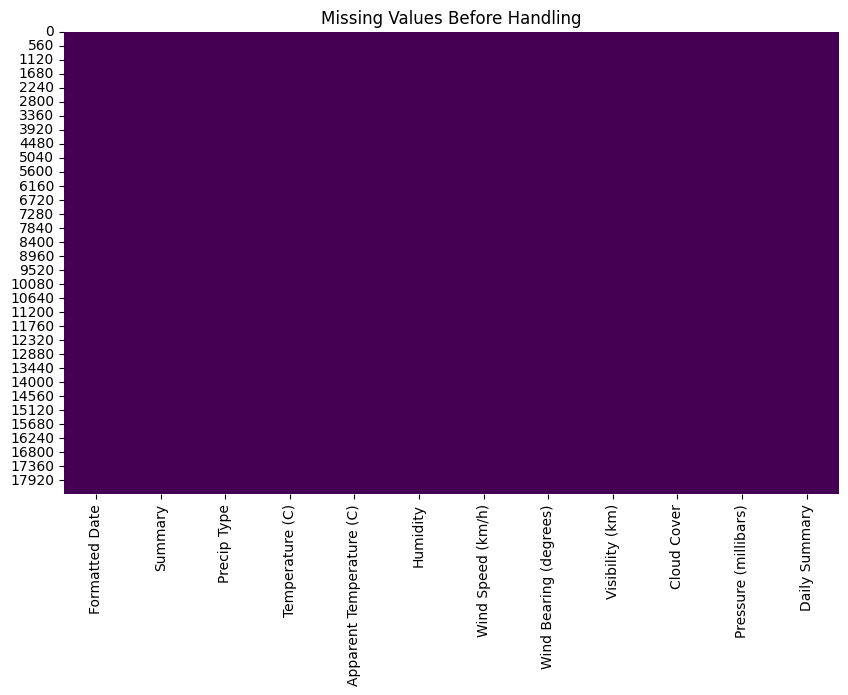

In [6]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Before Handling')
plt.show()

In [7]:
df.dropna(inplace=True)
df['Formatted Date'] = pd.to_datetime(df['Formatted Date'], utc=True)
df['Hour'] = df['Formatted Date'].dt.hour
df['Month'] = df['Formatted Date'].dt.month
df['Day'] = df['Formatted Date'].dt.day
df['Weekday'] = df['Formatted Date'].dt.weekday
df.drop(columns=['Formatted Date', 'Daily Summary'], inplace=True)
df.head()

,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Cloud Cover,Pressure (millibars),Hour,Month,Day,Weekday
0,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,22,3,31,4
1,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,23,3,31,4
2,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,0,4,1,5
3,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,1,4,1,5
4,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,2,4,1,5


In [8]:
print(df.isnull().sum())


Summary                     0
Precip Type                 0
Temperature (C)             0
Apparent Temperature (C)    0
Humidity                    0
Wind Speed (km/h)           0
Wind Bearing (degrees)      0
Visibility (km)             0
Cloud Cover                 0
Pressure (millibars)        0
Hour                        0
Month                       0
Day                         0
Weekday                     0
dtype: int64


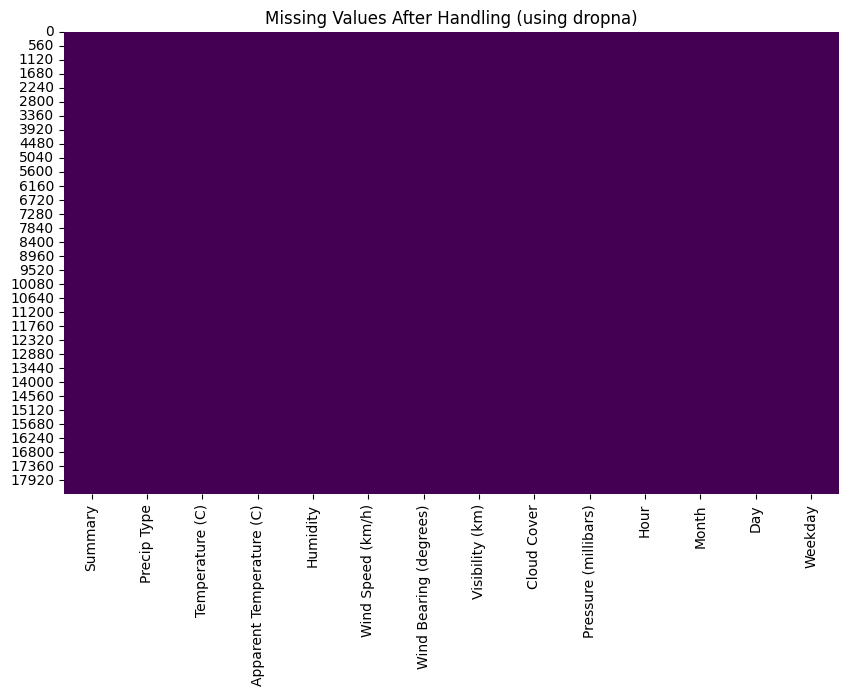

In [9]:
# Visualisasi missing value setelah penanganan (setelah dropna)
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values After Handling (using dropna)')
plt.show()

### 6. EDA

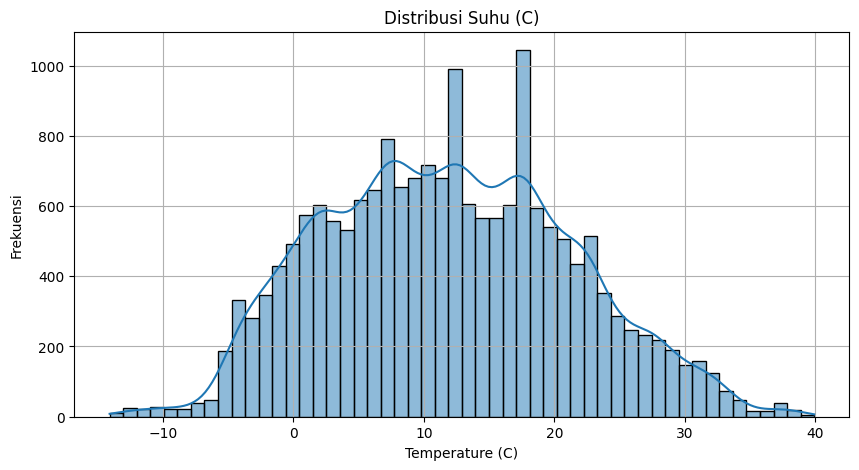

In [10]:
plt.figure(figsize=(10, 5))
sns.histplot(df['Temperature (C)'], kde=True)
plt.title("Distribusi Suhu (C)")
plt.xlabel("Temperature (C)")
plt.ylabel("Frekuensi")
plt.grid(True)
plt.show()



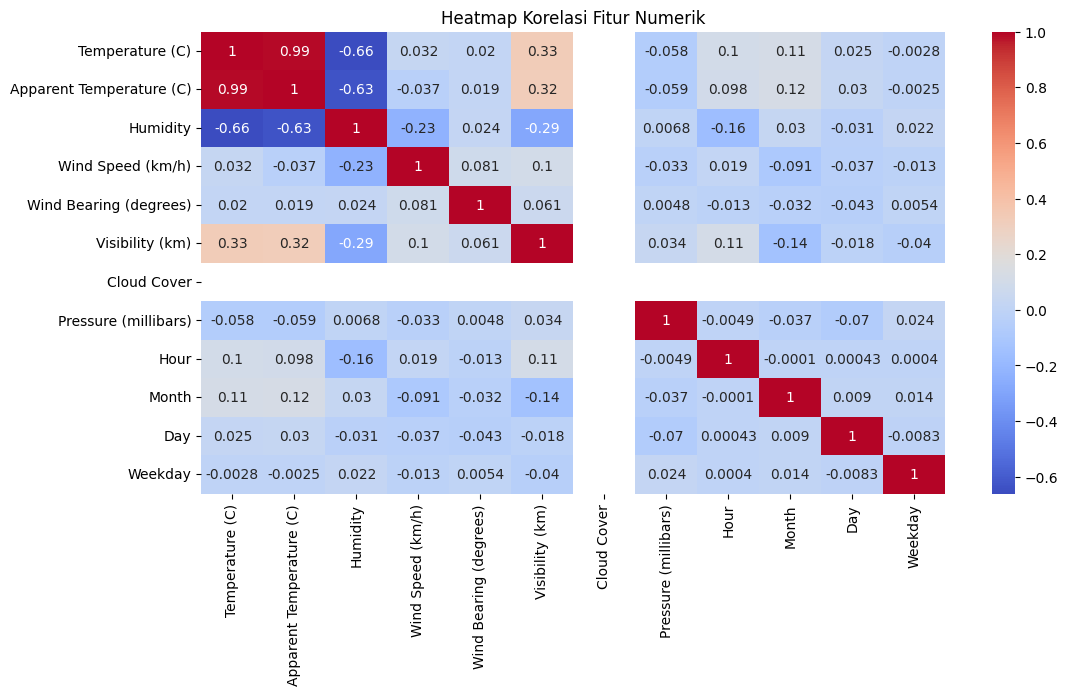

In [11]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Heatmap Korelasi Fitur Numerik")
plt.show()

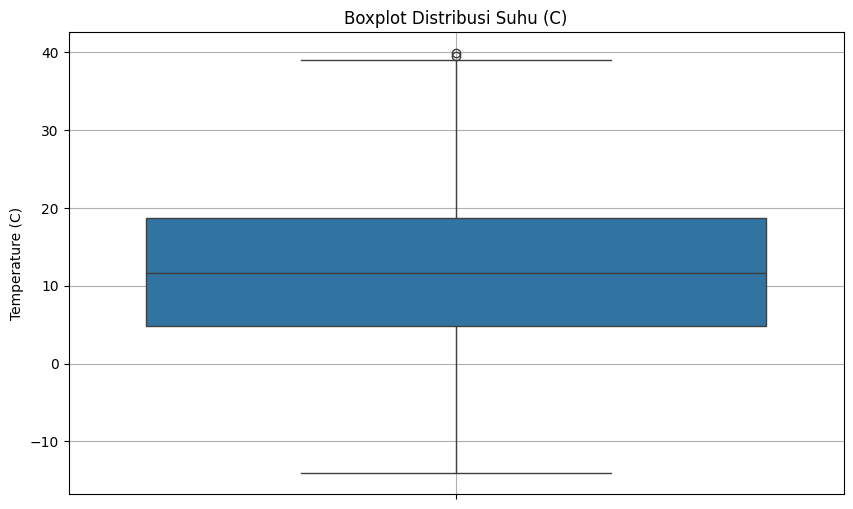


Statistik Deskriptif untuk Temperature (C):
count    18460.000000
mean        11.831738
std          9.431906
min        -14.088889
25%          4.866667
50%         11.644444
75%         18.662500
max         39.905556
Name: Temperature (C), dtype: float64

Skewness dari Temperature (C):
0.1539323768712321


In [12]:
# Analisis Ketidakseimbangan Data
# Pada kasus regresi, ketidakseimbangan data lebih mengacu pada distribusi nilai target.

plt.figure(figsize=(10, 6))
sns.boxplot(y=df['Temperature (C)'])
plt.title('Boxplot Distribusi Suhu (C)')
plt.ylabel('Temperature (C)')
plt.grid(True)
plt.show()

# Statistik deskriptif untuk melihat nilai minimum, maksimum, dan kuartil
print("\nStatistik Deskriptif untuk Temperature (C):")
print(df['Temperature (C)'].describe())

# Skewness dari distribusi suhu
print("\nSkewness dari Temperature (C):")
print(df['Temperature (C)'].skew())


### 7.  Preprocessing dan Transformasi

In [13]:
X = df.drop(columns=['Temperature (C)'])
y = df['Temperature (C)']

cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

### 8. Split dan Training Model

In [28]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Buat pipeline Random Forest Regression
model = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])



In [15]:
# Grid Search untuk tuning hyperparameter
param_grid = {
    'regressor__n_estimators': [100, 150],
    'regressor__max_depth': [10, 15, None]
}

from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(model, param_grid, cv=3, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Simpan model terbaik dari tuning
print("Best parameters dari GridSearch:", grid_search.best_params_)
best_model = grid_search.best_estimator_


Best parameters dari GridSearch: {'regressor__max_depth': 15, 'regressor__n_estimators': 150}


In [16]:
# Evaluasi performa dengan cross-validation pada data training
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='r2')

print("Hasil Cross-Validation R² Score (5-fold):", cv_scores)
print(f"Rata-rata R² dari CV: {cv_scores.mean():.3f}")


Hasil Cross-Validation R² Score (5-fold): [0.99990561 0.9998585  0.99985879 0.99991998 0.9998929 ]
Rata-rata R² dari CV: 1.000


In [20]:
# Buat pipeline Linear Regression
lr_model = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', LinearRegression())
])

# Latih model Linear Regression
lr_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Apparent Temperature (C)',
                                                   'Humidity',
                                                   'Wind Speed (km/h)',
                                                   'Wind Bearing (degrees)',
                                                   'Visibility (km)',
                                                   'Cloud Cover',
                                                   'Pressure (millibars)']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Summary',
                                                   'Precip Type'])])),
                ('regressor', LinearRegression())])

### 9.  Evaluasi Model

In [30]:
# Prediksi dari Random Forest (model terbaik dari GridSearch)
y_pred_rf = best_model.predict(X_test)

# Prediksi dari Linear Regression
y_pred_lr = lr_model.predict(X_test)

# Evaluasi Random Forest
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

# Evaluasi Linear Regression
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)

# Cetak hasil evaluasi
print("=== Random Forest Evaluation ===")
print(f"RMSE : {rmse_rf:.3f}")
print(f"R²   : {r2_rf:.3f}")
print(f"MAE  : {mae_rf:.3f}")

print("\n=== Linear Regression Evaluation ===")
print(f"RMSE : {rmse_lr:.3f}")
print(f"R²   : {r2_lr:.3f}")
print(f"MAE  : {mae_lr:.3f}")

=== Random Forest Evaluation ===
RMSE : 0.100
R²   : 1.000
MAE  : 0.030

=== Linear Regression Evaluation ===
RMSE : 0.937
R²   : 0.990
MAE  : 0.737


### VISUALISASI

## 10.Perbandingan Kinerja Model

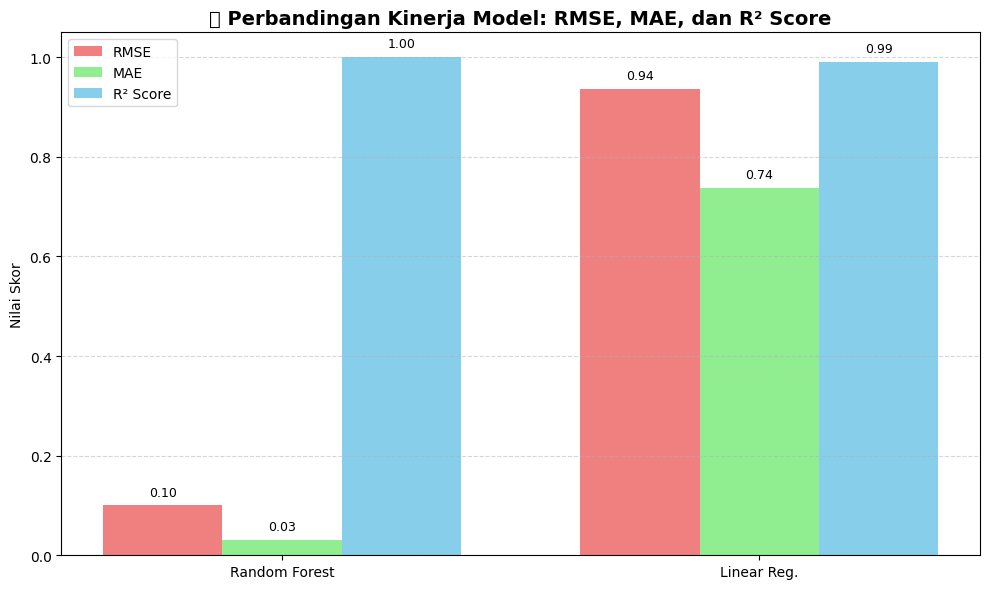

In [31]:
labels = ['Random Forest', 'Linear Reg.']
rmse_values = [rmse_rf, rmse_lr]
r2_values = [r2_rf, r2_lr]
mae_values = [mae_rf, mae_lr]

x = np.arange(len(labels))  # indeks model
width = 0.25  # lebar tiap bar

fig, ax = plt.subplots(figsize=(10, 6))

# Buat 3 batang untuk tiap metrik
bars1 = ax.bar(x - width, rmse_values, width, label='RMSE', color='#f08080')
bars2 = ax.bar(x, mae_values, width, label='MAE', color='#90ee90')
bars3 = ax.bar(x + width, r2_values, width, label='R² Score', color='#87ceeb')

# Tampilkan nilai di atas tiap bar
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

# Label dan tampilan
ax.set_ylabel('Nilai Skor')
ax.set_title('📊 Perbandingan Kinerja Model: RMSE, MAE, dan R² Score', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=10)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


## 11. Feature Importance

Visualisasi feature importance digunakan untuk mengetahui fitur mana yang paling berpengaruh terhadap hasil prediksi.

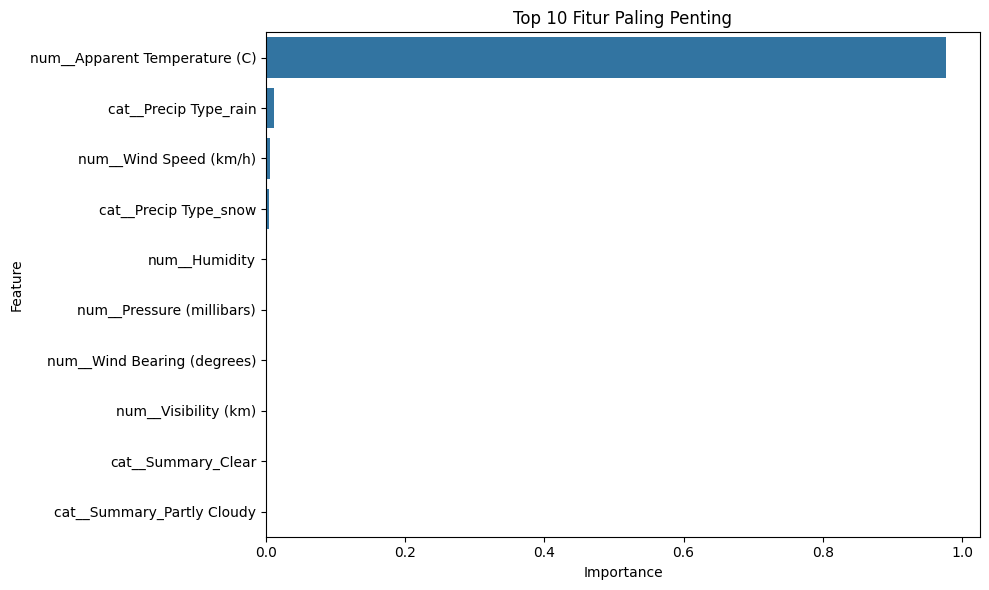

In [32]:
# Tampilkan pentingnya fitur
rf_model = best_model.named_steps['regressor']
if hasattr(rf_model, 'feature_importances_'):
    feature_names = model.named_steps['preprocessing'].get_feature_names_out()
    importances = rf_model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
    plt.title("Top 10 Fitur Paling Penting")
    plt.tight_layout()
    plt.show()


## 12.prediksi vs aktual

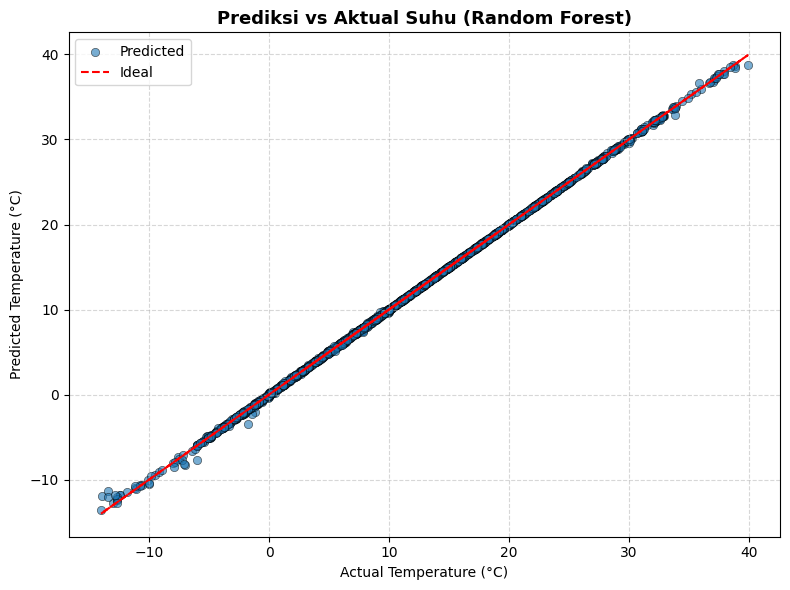

In [33]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.6, label='Predicted', edgecolor='k', linewidth=0.5)
plt.plot(y_test, y_test, 'r--', label='Ideal')  # garis y=x

plt.xlabel("Actual Temperature (°C)")
plt.ylabel("Predicted Temperature (°C)")
plt.title("Prediksi vs Aktual Suhu (Random Forest)", fontsize=13, fontweight='bold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


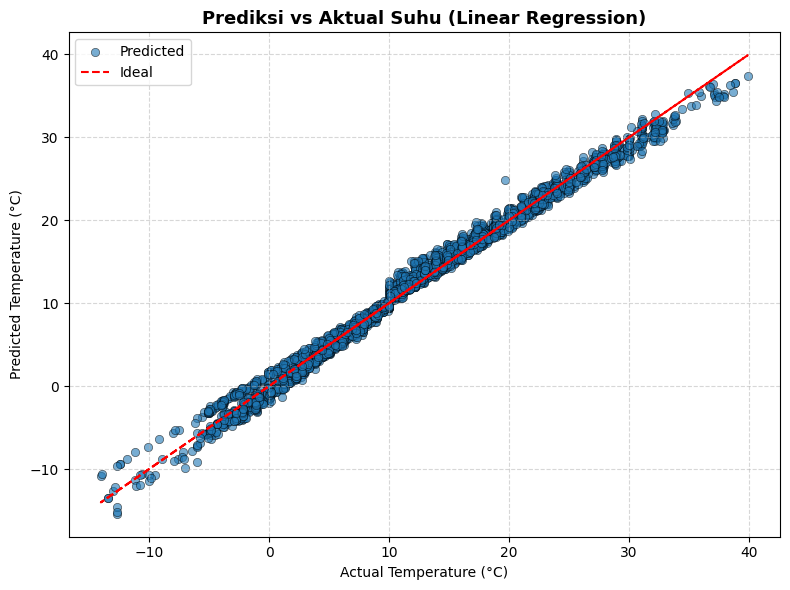

In [34]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.6, label='Predicted', edgecolor='k', linewidth=0.5)
plt.plot(y_test, y_test, 'r--', label='Ideal')  # garis y=x

plt.xlabel("Actual Temperature (°C)")
plt.ylabel("Predicted Temperature (°C)")
plt.title("Prediksi vs Aktual Suhu (Linear Regression)", fontsize=13, fontweight='bold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## 13.RESIDUAL PLOT

Menunjukkan distribusi error (prediksi - aktual). Residual plot yang acak mengindikasikan model bekerja baik.

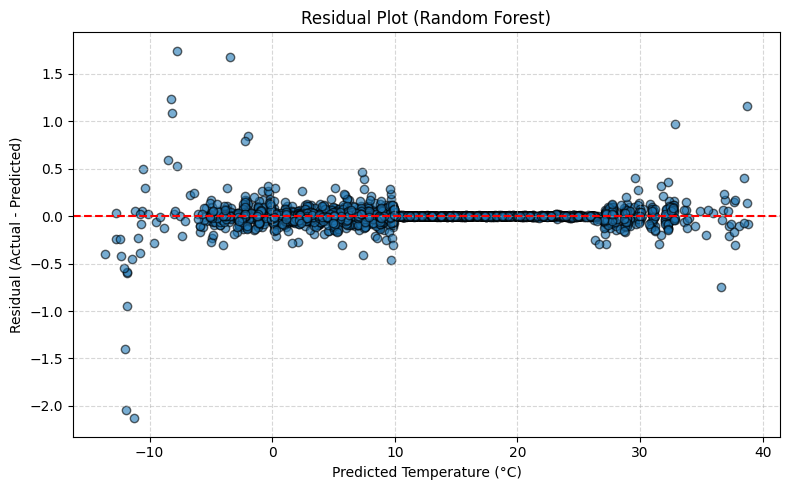

In [35]:
residuals_rf = y_test - y_pred_rf

plt.figure(figsize=(8, 5))
plt.scatter(y_pred_rf, residuals_rf, alpha=0.6, edgecolor='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Temperature (°C)")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot (Random Forest)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


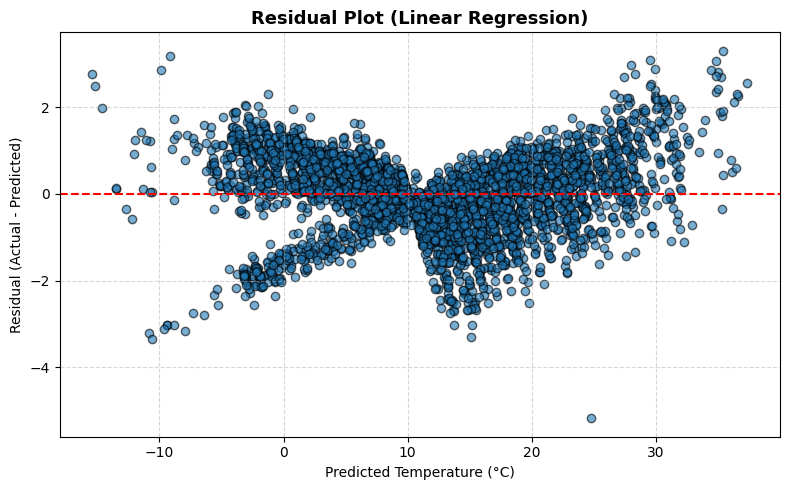

In [36]:
# Hitung residual (selisih antara nilai aktual dan prediksi)
residuals_lr = y_test - y_pred_lr

# Visualisasi residual plot
plt.figure(figsize=(8, 5))
plt.scatter(y_pred_lr, residuals_lr, alpha=0.6, edgecolor='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Temperature (°C)")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot (Linear Regression)", fontsize=13, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### **Kesimpulan**

Dalam proyek tugas besar mata kuliah *Artificial Intelligence* ini, kami membangun dan membandingkan dua model regresi — **Random Forest Regressor** dan **Linear Regression** — untuk memprediksi **suhu udara harian** berdasarkan data historis cuaca.

Berdasarkan evaluasi performa model menggunakan metrik **MSE**, **RMSE**, **MAE**, dan **R² Score**, serta didukung dengan visualisasi prediksi dan *residual plot*, hasilnya menunjukkan bahwa:

🔹 **Random Forest Regressor memberikan performa yang secara konsisten lebih unggul** dibandingkan Linear Regression.  
🔹 Model ini mampu meminimalkan kesalahan prediksi dan menangkap hubungan non-linear dalam data dengan lebih baik.  
🔹 Visualisasi *residual plot* pada Random Forest juga menunjukkan sebaran error yang lebih stabil dan acak — karakteristik dari model yang bekerja baik.

Dengan mempertimbangkan semua hasil evaluasi, maka:

**Kami memilih Random Forest sebagai algoritma model yang digunakan dalam proyek ini**, karena terbukti lebih akurat, andal, dan sesuai dengan kompleksitas data cuaca yang digunakan.
